In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error # モデル評価用(平均二乗誤差)
from sklearn.metrics import r2_score # モデル評価用(決定係数)
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor as RFR
import xgboost as xgb
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PowerTransformer
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test_x = pd.read_csv('test.csv')

train.shape

(3000, 49)

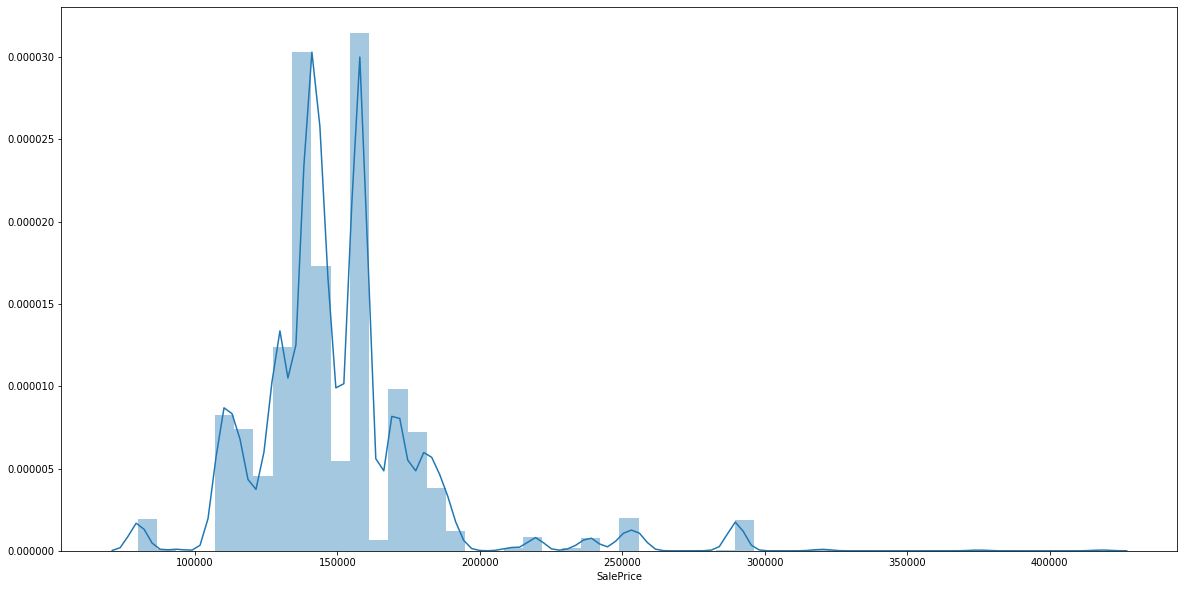

In [3]:
plt.figure(figsize=(20, 10))
sns.distplot(train['SalePrice'])

In [4]:
print("歪度: %f" % train['SalePrice'].skew())
print("尖度: %f" % train['SalePrice'].kurt())

歪度: 2.059224
尖度: 8.604152


Text(0, 0.5, 'SalePrice')

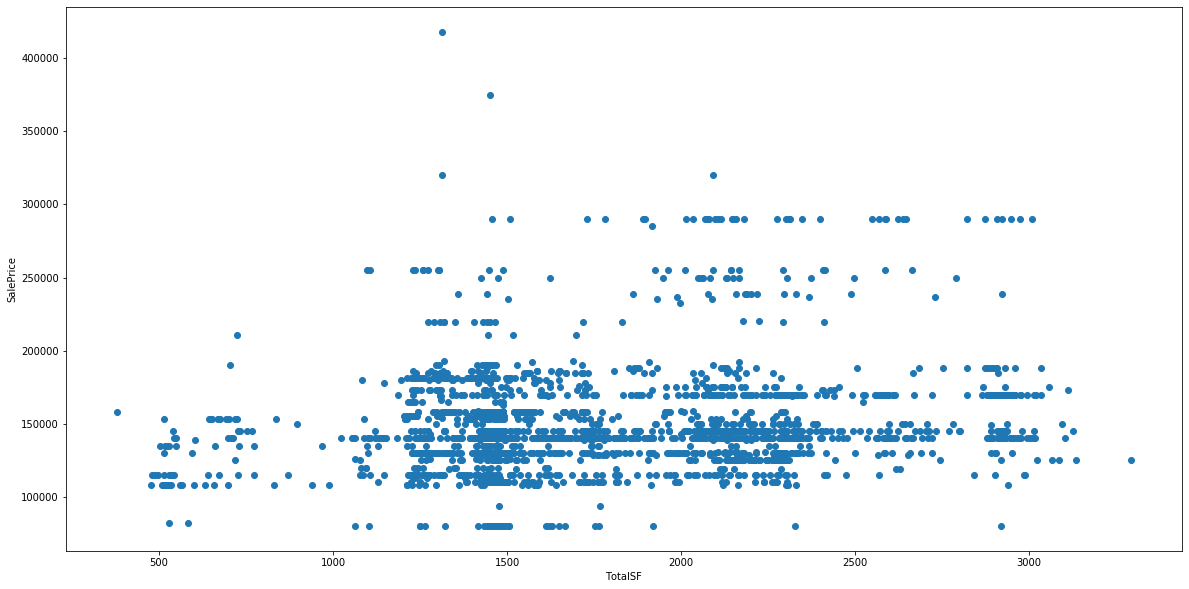

In [5]:
train["TotalSF"] = train["1st Flr SF"] + train["2nd Flr SF"] + train["Total Bsmt SF"]
test_x["TotalSF"] = test_x["1st Flr SF"] + test_x["2nd Flr SF"] + test_x["Total Bsmt SF"]

plt.figure(figsize=(20, 10))
plt.scatter(train["TotalSF"],train["SalePrice"])
plt.xlabel("TotalSF")
plt.ylabel("SalePrice")

Text(0, 0.5, 'SalePrice')

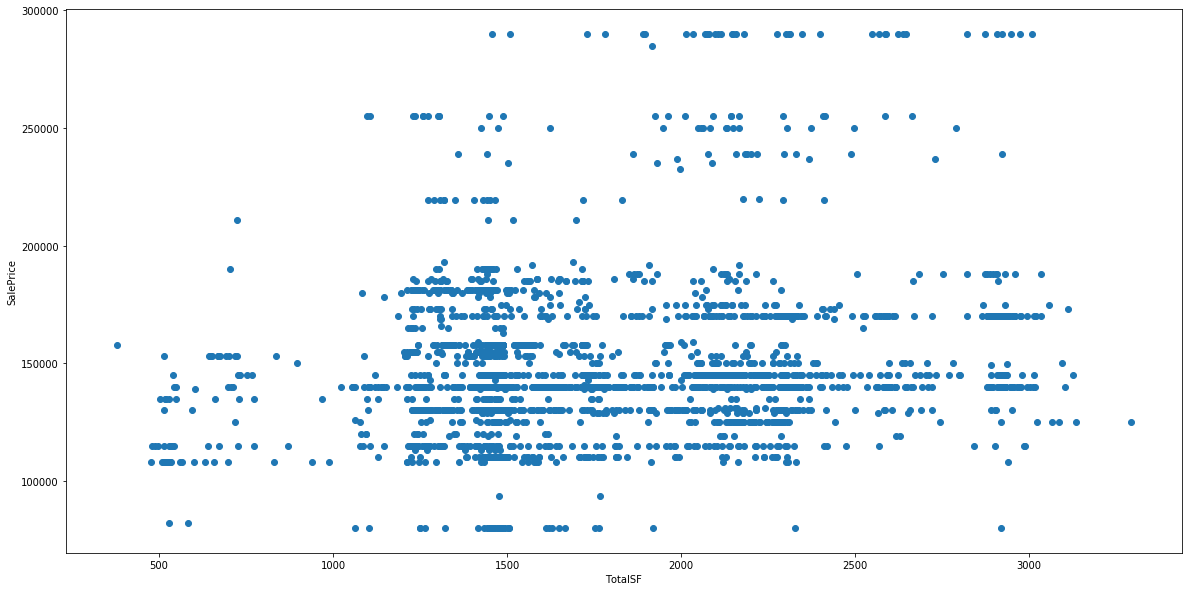

In [6]:
#外れ値を除外する
train = train.drop(train[train['SalePrice']>300000].index)
#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(20, 10))
plt.scatter(train["TotalSF"],train["SalePrice"])
plt.xlabel("TotalSF")
plt.ylabel("SalePrice")

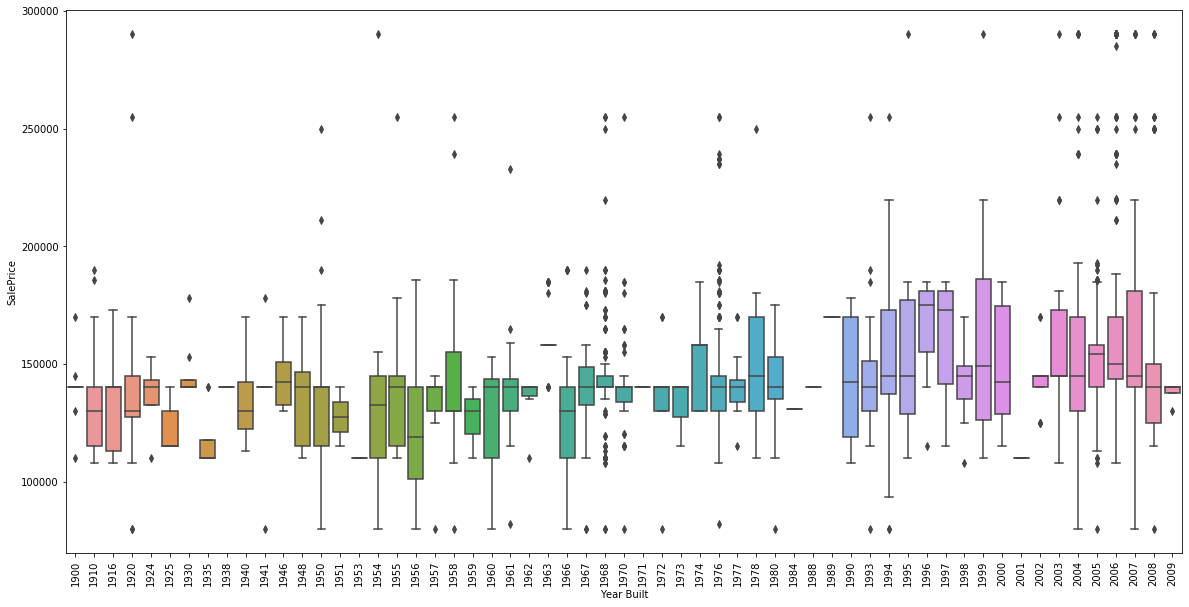

In [7]:
data = pd.concat([train["Year Built"],train["SalePrice"]],axis=1)

plt.figure(figsize=(20, 10))
plt.xticks(rotation='90')
sns.boxplot(x="Year Built",y="SalePrice",data=data)

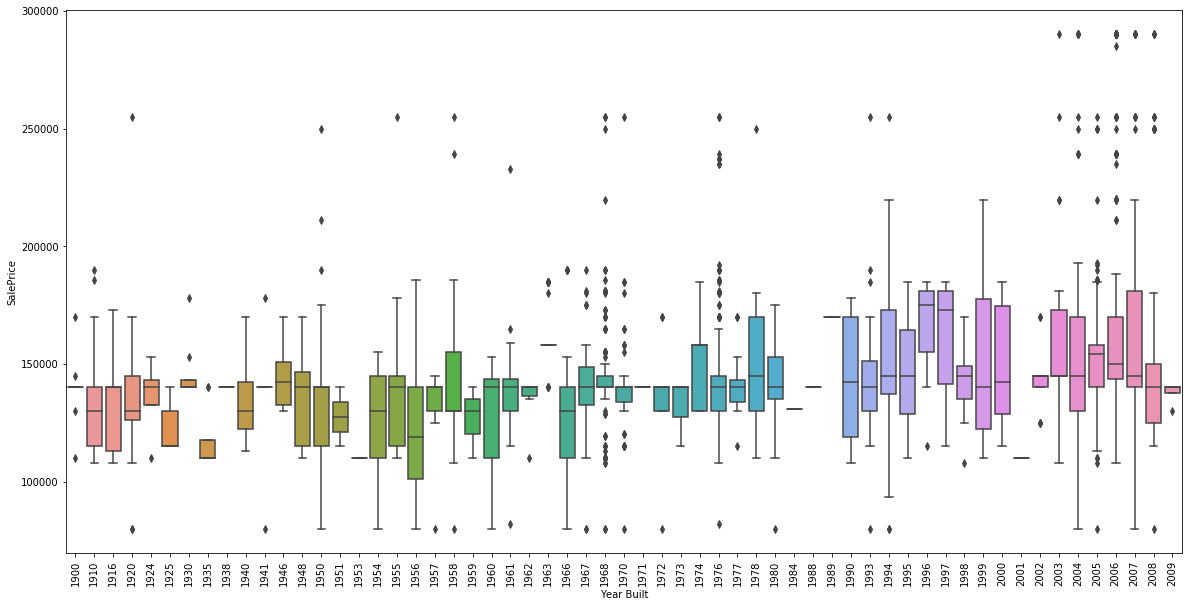

In [8]:
#外れ値を除外する
train = train.drop(train[(train['Year Built']<2000) & (train['SalePrice']>270000)].index)

#グラフを描画する
data = pd.concat([train["Year Built"],train["SalePrice"]],axis=1)

plt.figure(figsize=(20, 10))
plt.xticks(rotation='90')
sns.boxplot(x="Year Built",y="SalePrice",data=data)

Text(0, 0.5, 'SalePrice')

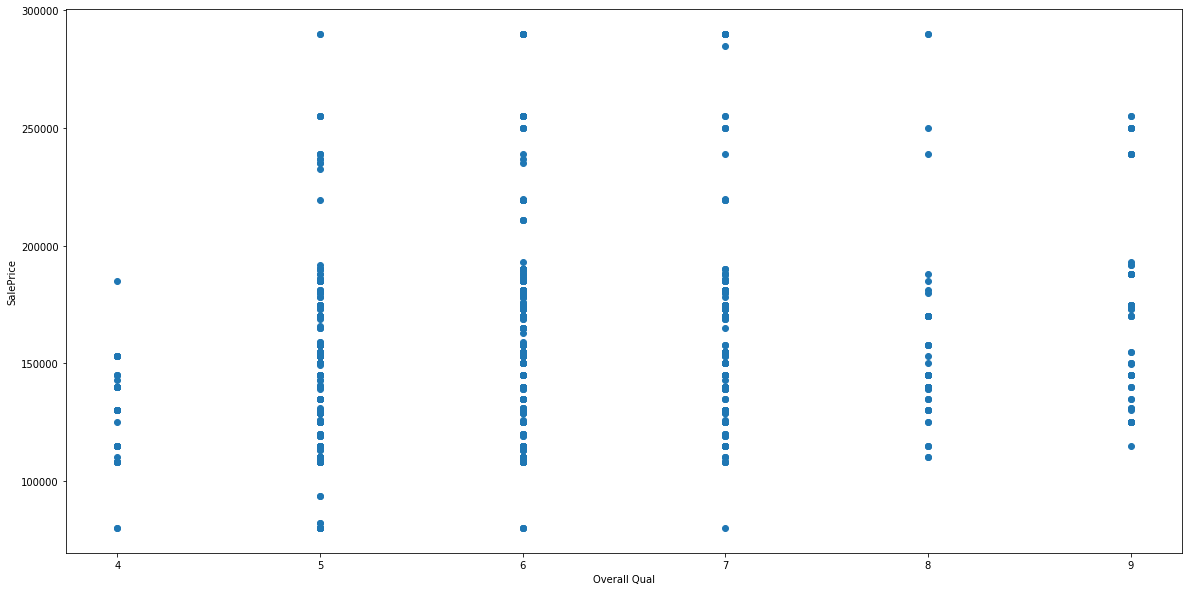

In [9]:
plt.figure(figsize=(20, 10))
plt.scatter(train["Overall Qual"],train["SalePrice"])
plt.xlabel("Overall Qual")
plt.ylabel("SalePrice")

Text(0, 0.5, 'SalePrice')

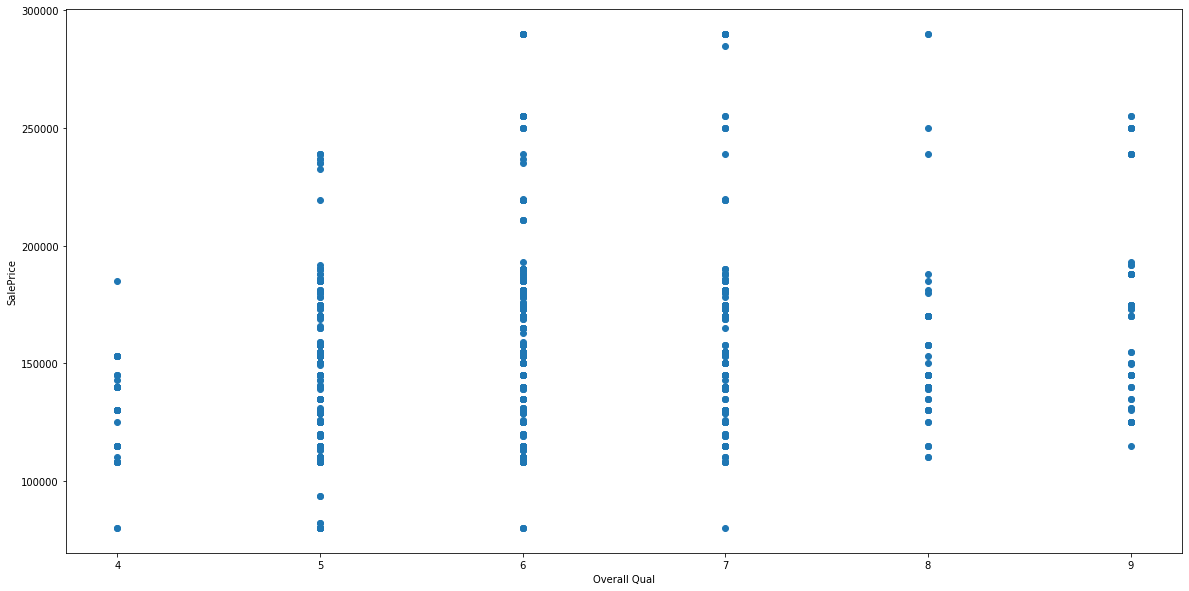

In [10]:
train = train.drop(train[(train['Overall Qual']<6) & (train['SalePrice']>250000)].index)

#グラフを描画する
plt.figure(figsize=(20, 10))
plt.scatter(train["Overall Qual"],train["SalePrice"])
plt.xlabel("Overall Qual")
plt.ylabel("SalePrice")


In [14]:
train_x = train.drop("SalePrice",axis=1)
train_y = train["SalePrice"]

#学習データとテストデータを統合
all_data = pd.concat([train_x,test_x],axis=0,sort=True)

#IDのカラムは不必要なので別の変数に格納
train_ID = train['index']
test_ID = test_x['index']

all_data.drop("index", axis = 1, inplace = True)

#それぞれのデータのサイズを確認
print("train_x: "+str(train_x.shape))
print("train_y: "+str(train_y.shape))
print("test_x: "+str(test_x.shape))
print("all_data: "+str(all_data.shape))


train_x: (2985, 49)
train_y: (2985,)
test_x: (2000, 49)
all_data: (4985, 48)


In [21]:
all_data['MS SubClass'] = all_data['MS SubClass'].apply(str)
all_data['Yr Sold'] = all_data['Yr Sold'].astype(str)
all_data['Mo Sold'] = all_data['Mo Sold'].astype(str)

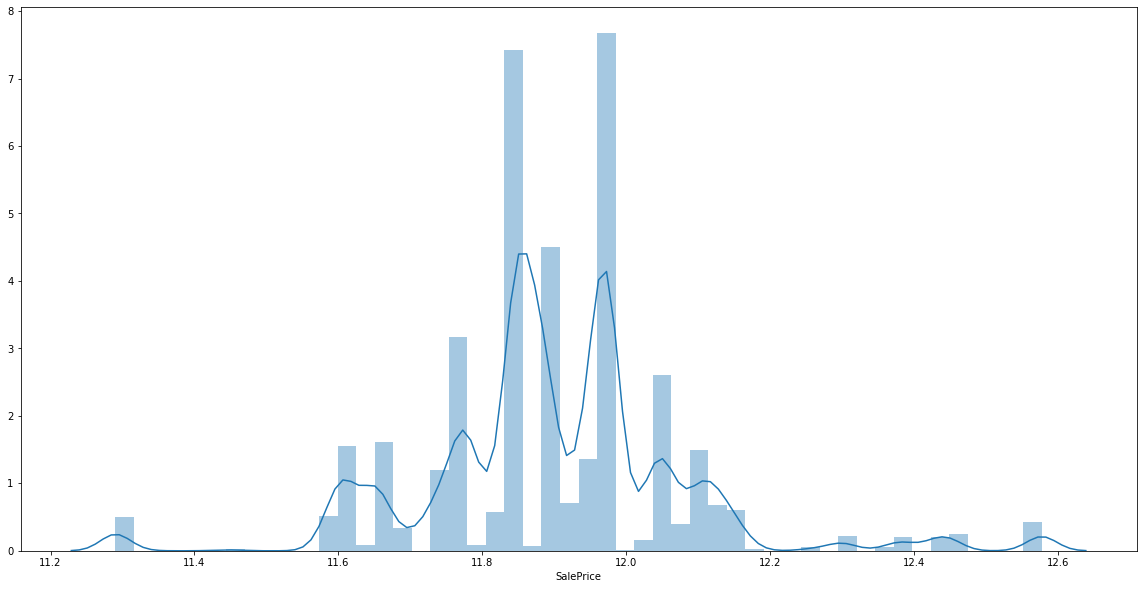

In [22]:
train_y = np.log1p(train_y)

#分布を可視化
plt.figure(figsize=(20, 10))
sns.distplot(train_y)

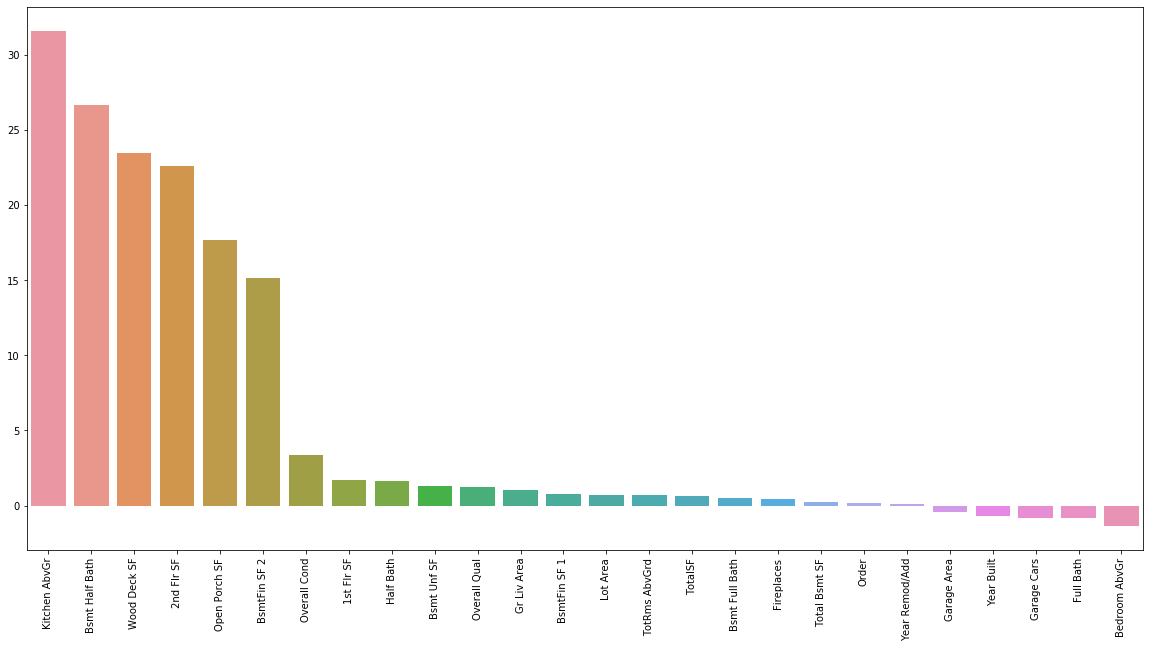

In [23]:
#数値の説明変数のリストを作成
num_feats = all_data.dtypes[all_data.dtypes != "object" ].index

#各説明変数の歪度を計算
skewed_feats = all_data[num_feats].apply(lambda x: x.skew()).sort_values(ascending = False)

#グラフ化
plt.figure(figsize=(20,10))
plt.xticks(rotation='90')
sns.barplot(x=skewed_feats.index, y=skewed_feats)

In [24]:
#歪度の絶対値が0.5より大きい変数だけに絞る
skewed_feats_over = skewed_feats[abs(skewed_feats) > 0.5].index

In [25]:
for i in skewed_feats_over:
    print(min(all_data[i]))

1
-0.001999957
0
0
0
-0.001879712
3
483
0
31.7869408
4
800
0.000298115
1680
4
320.840228
1900
-0.001999405
1
1


In [28]:
#Yeo-Johnson変換
pt = PowerTransformer()
pt.fit(all_data[skewed_feats_over])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

In [29]:
#変換後のデータで各列を置換
all_data[skewed_feats_over] = pt.transform(all_data[skewed_feats_over])

In [33]:
#バスルームの合計面積
all_data['Total_Bathrooms'] = (all_data['Full Bath'] + (0.5 * all_data['Half Bath']) +
                               all_data['Bsmt Full Bath'] + (0.5 * all_data['Bsmt Half Bath']))
#2階の有無
all_data['has2ndfloor'] = all_data['2nd Flr SF'].apply(lambda x: 1 if x > 0 else 0)

#ガレージの有無
all_data['hasgarage'] = all_data['Garage Area'].apply(lambda x: 1 if x > 0 else 0)

#地下室の有無
all_data['hasbsmt'] = all_data['Total Bsmt SF'].apply(lambda x: 1 if x > 0 else 0)

#暖炉の有無
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [35]:
train.columns.values
#各カラムのデータ型を確認
all_data.dtypes.value_counts()

float64    24
object     22
int64       7
dtype: int64

In [36]:
#カテゴリ変数となっているカラムを取り出す
cal_list = all_data.dtypes[all_data.dtypes=="object"].index.tolist()


In [37]:
all_data = pd.get_dummies(all_data,columns=cal_list)

#サイズを確認
all_data.shape


(4985, 148)

In [39]:
#学習データとテストデータに再分割
train_x = all_data.iloc[:train_x.shape[0],:].reset_index(drop=True)
test_x = all_data.iloc[train_x.shape[0]:,:].reset_index(drop=True)
#サイズを確認
print("train_x: "+str(train_x.shape))
print("test_x: "+str(test_x.shape))

train_x: (2985, 148)
test_x: (2000, 148)


In [48]:
# データの分割
train_x, valid_x, train_y, valid_y = train_test_split(
        train_x,
        train_y,
        test_size=0.3,
        random_state=7)

In [49]:
#特徴量と目的変数をxgboostのデータ構造に変換する
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x,label=valid_y)

In [50]:
#パラメータを指定してGBDT
num_round = 5000
evallist = [(dvalid, 'eval'), (dtrain, 'train')]

evals_result = {}

#パラメータ
param = {
            'max_depth': 3,
            'eta': 0.01,
            'objective': 'reg:squarederror',
}

#学習の実行
bst = xgb.train(
                        param, dtrain,
                        num_round,
                        evallist,
                        evals_result=evals_result,
                        # 一定ラウンド回しても改善が見込めない場合は学習を打ち切る
                        early_stopping_rounds=1000
                        )

#bst = xgb.train(param, dtrain, num_round)

#[4999]	eval-rmse:0.124586	train-rmse:0.075149
#[4999]	eval-rmse:0.118845	train-rmse:0.073414

[0]	eval-rmse:11.2871	train-rmse:11.2899
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 1000 rounds.
[1]	eval-rmse:11.1743	train-rmse:11.1771
[2]	eval-rmse:11.0627	train-rmse:11.0654
[3]	eval-rmse:10.9521	train-rmse:10.9549
[4]	eval-rmse:10.8427	train-rmse:10.8454
[5]	eval-rmse:10.7343	train-rmse:10.7371
[6]	eval-rmse:10.6271	train-rmse:10.6298
[7]	eval-rmse:10.5209	train-rmse:10.5236
[8]	eval-rmse:10.4157	train-rmse:10.4185
[9]	eval-rmse:10.3117	train-rmse:10.3144
[10]	eval-rmse:10.2086	train-rmse:10.2114
[11]	eval-rmse:10.1066	train-rmse:10.1094
[12]	eval-rmse:10.0056	train-rmse:10.0084
[13]	eval-rmse:9.90561	train-rmse:9.90838
[14]	eval-rmse:9.80664	train-rmse:9.80941
[15]	eval-rmse:9.70864	train-rmse:9.7114
[16]	eval-rmse:9.61163	train-rmse:9.61437
[17]	eval-rmse:9.51559	train-rmse:9.51835
[18]	eval-rmse:9.4205	train-rmse:9.42326
[19]	eval-rmse:9.32637	train-rmse:9.32914
[20]	eval-rmse:9.23318	tr

In [51]:
bst.predict(dtrain)

array([11.796626, 11.979489, 11.952511, ..., 11.837007, 11.904082,
       11.846519], dtype=float32)

In [53]:
dtest = xgb.DMatrix(test_x)

my_submission = pd.DataFrame()
my_submission["Id"] = test_ID
my_submission["SalePrice"] = np.exp(bst.predict(dtest))
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)